In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
start='2014-01-01'
end='2017-12-31'

In [15]:
tickers = ['AAPL','MSFT','GOOG']
#df = pd.DataFrame()
#for t in tickers:
df = pdr.DataReader(tickers, 'yahoo',start,end)
  
''' NOT NEEDED
  dftemp.reset_index(inplace=True)
  dftemp.set_index('Date', inplace=True)
  
  dftemp.drop(['Volume', 'High','Low','Open','Close'],1,inplace=True)
  df.rename(columns={'Adj Close':t}, inplace=True)
  print(dftemp.head(2))
  if df.empty:
    df = dftemp
  else:
    df = df.join(dftemp, how='outer')
    '''
print(df.head(3))

Attributes       High                         ...  Adj Close                       
Symbols          AAPL        GOOG       MSFT  ...       AAPL        GOOG       MSFT
Date                                          ...                                  
2014-01-02  79.575714  556.788025  37.400002  ...  71.320679  554.481689  32.582050
2014-01-03  79.099998  556.379578  37.220001  ...  69.754066  550.436829  32.362835
2014-01-06  78.114288  557.340942  36.889999  ...  70.134438  556.573853  31.678938

[3 rows x 18 columns]


In [16]:
close = df['Adj Close']
print(close[-2:])

all_weekdays = pd.date_range(start=start, end=end, freq='B')
print(all_weekdays[-2:])

# align existing prices in adj close with new set of dats, reindex close using all weekdays
close = close.reindex(all_weekdays)
print(close[-2:])

#replace missing data, forward fill'
close = close.fillna(method='ffill')

Symbols           AAPL         GOOG       MSFT
Date                                          
2017-12-28  166.553101  1048.140015  83.316124
2017-12-29  164.752060  1046.400024  83.141182
DatetimeIndex(['2017-12-28', '2017-12-29'], dtype='datetime64[ns]', freq='B')
Symbols           AAPL         GOOG       MSFT
2017-12-28  166.553101  1048.140015  83.316124
2017-12-29  164.752060  1046.400024  83.141182


In [17]:
close.describe()

Symbols,AAPL,GOOG,MSFT
count,1042.000000,1042.000000,1042.000000
mean,110.127077,706.346570,50.381351
std,25.127398,153.796575,12.991165
min,64.441742,491.201416,30.670612
25%,92.447876,562.691498,40.343418
50%,106.252281,706.035004,47.973701
75%,120.132206,797.044998,59.582140
max,171.751816,1077.140015,84.414436


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


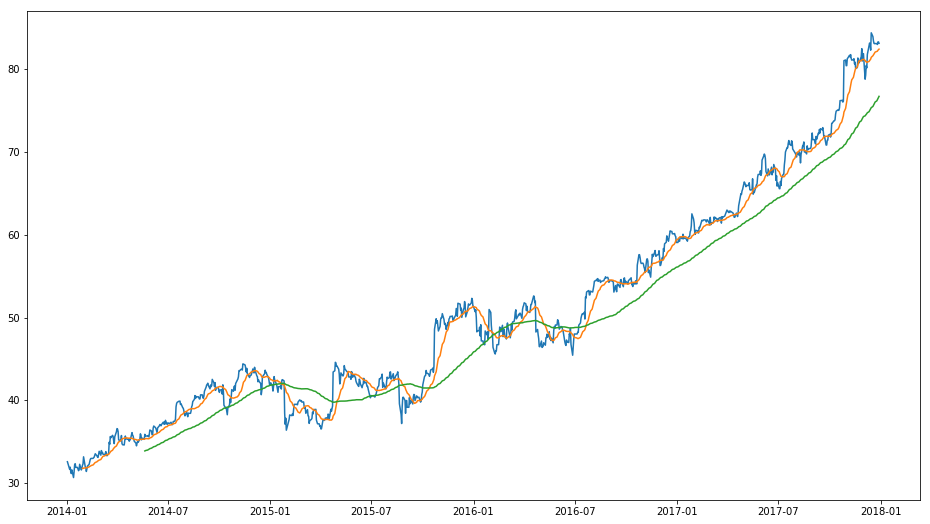

In [18]:
# plot timeseries and rolling means
msft = close.loc[:,'MSFT']

short_mavg = msft.rolling(window=20).mean()
long_mavg = msft.rolling(window=100).mean()

# plot
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(msft.index, msft, label='msft')
ax.plot(short_mavg.index, short_mavg, label='20ma')
ax.plot(long_mavg.index, long_mavg, label='10ma')


In [20]:
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

# short rolling ma for all
short_rolling = close.rolling(window=20).mean()
# long rolling ma
long_rolling = close.rolling(window=100).mean()
long_rolling.tail()

Symbols,AAPL,GOOG,MSFT
2017-12-25,159.216211,981.519998,76.188473
2017-12-26,159.329992,982.819498,76.318303
2017-12-27,159.434596,984.084198,76.454224
2017-12-28,159.593442,985.493198,76.600439
2017-12-29,159.713324,986.813298,76.734419


In [21]:
# calculate returns and log returns = log (p(t)/p(t-1)) or relative price = p(t)-p(t-1)/p(t-1)
returns = close.pct_change(1)
print(returns.head())
log_returns = np.log(close).diff()
print(log_returns.head())

Symbols         AAPL      GOOG      MSFT
2014-01-01       NaN       NaN       NaN
2014-01-02       NaN       NaN       NaN
2014-01-03 -0.021966 -0.007295 -0.006728
2014-01-06  0.005453  0.011149 -0.021132
2014-01-07 -0.007152  0.019278  0.007750
Symbols         AAPL      GOOG      MSFT
2014-01-01       NaN       NaN       NaN
2014-01-02       NaN       NaN       NaN
2014-01-03 -0.022211 -0.007322 -0.006751
2014-01-06  0.005438  0.011088 -0.021359
2014-01-07 -0.007177  0.019095  0.007720


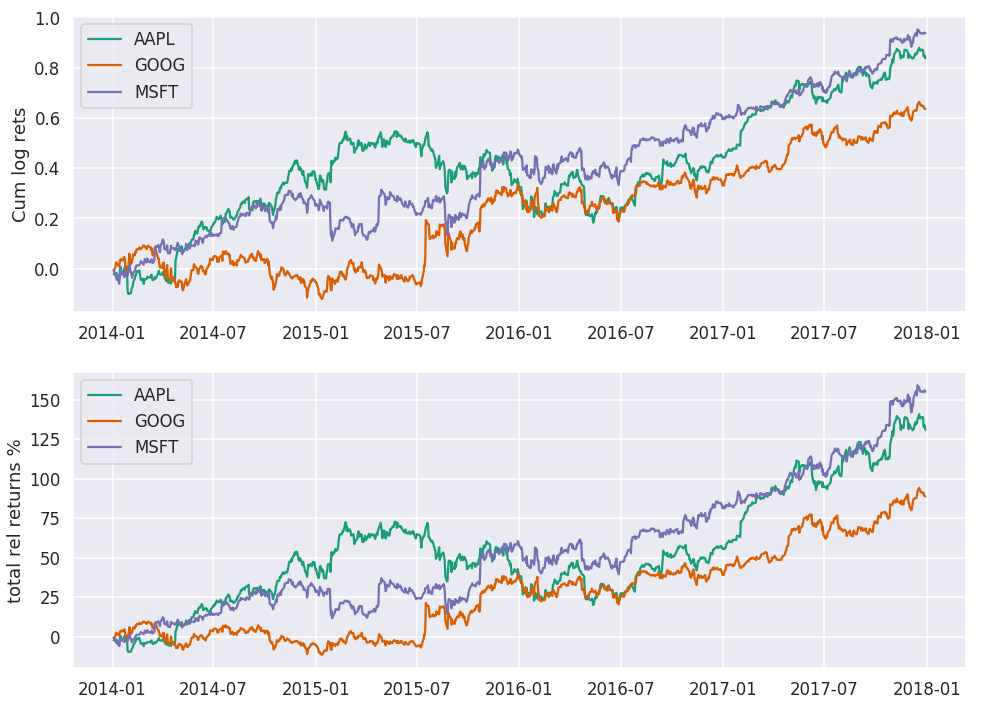

In [23]:
# since log returns are additive, we can create time series of cumulative log-returns
# then convert to relative returns (easier to see value growth) - relative c(t) = e^c(t) -1
# plot cum returns
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,12))
for c in log_returns:
  ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))
ax1.set_ylabel('Cum log rets')
ax1.legend(loc='best')

for c in log_returns:
  ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum())-1), label=str(c))
ax2.set_ylabel("total rel returns %")
ax2.legend(loc='best')
plt.show()

In [27]:
# last day of returns //  make this column vector
r_t = log_returns.tail(1).transpose()
r_t.index

Index(['AAPL', 'GOOG', 'MSFT'], dtype='object', name='Symbols')

In [28]:
# weights for K assets
weights_vector = pd.DataFrame(1/3, index=r_t.index, columns=r_t.columns)
weights_vector

,2017-12-29 00:00:00
Symbols,
AAPL,0.333333
GOOG,0.333333
MSFT,0.333333


In [29]:
# total log return for portfolio
portfolio_log_ret = weights_vector.transpose().dot(r_t)
portfolio_log_ret

,2017-12-29 00:00:00
2017-12-29,-0.004879


In [30]:
# diagonal extraction given 1/3 weights for all stocks w(aapl) = w(msft) = w(goog) == 1/3
weights_matrix = pd.DataFrame(1/3, index=close.index, columns=close.columns)
weights_matrix.tail()


Symbols,AAPL,GOOG,MSFT
2017-12-25,0.333333,0.333333,0.333333
2017-12-26,0.333333,0.333333,0.333333
2017-12-27,0.333333,0.333333,0.333333
2017-12-28,0.333333,0.333333,0.333333
2017-12-29,0.333333,0.333333,0.333333


In [31]:
#Matrix R  is simple log_returns dataframe
log_returns.head()

Symbols,AAPL,GOOG,MSFT
2014-01-01,NaN,NaN,NaN
2014-01-02,NaN,NaN,NaN
2014-01-03,-0.022211,-0.007322,-0.006751
2014-01-06,0.005438,0.011088,-0.021359
2014-01-07,-0.007177,0.019095,0.007720


In [32]:
# portfolio returns calculated
temp_var = weights_matrix.dot(log_returns.transpose())
temp_var.head().iloc[:,0:5]

,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00
2014-01-01,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-02,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-03,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-06,NaN,NaN,-0.012094,-0.001611,0.006546
2014-01-07,NaN,NaN,-0.012094,-0.001611,0.006546


In [33]:
# now can find the diag np.diag to extract series
portfolio_log_returns = pd.Series(np.diag(temp_var), index=log_returns.index)
portfolio_log_returns.tail()

2017-12-25    0.000000
2017-12-26   -0.010059
2017-12-27   -0.001066
2017-12-28    0.000584
2017-12-29   -0.004879
Freq: B, dtype: float64

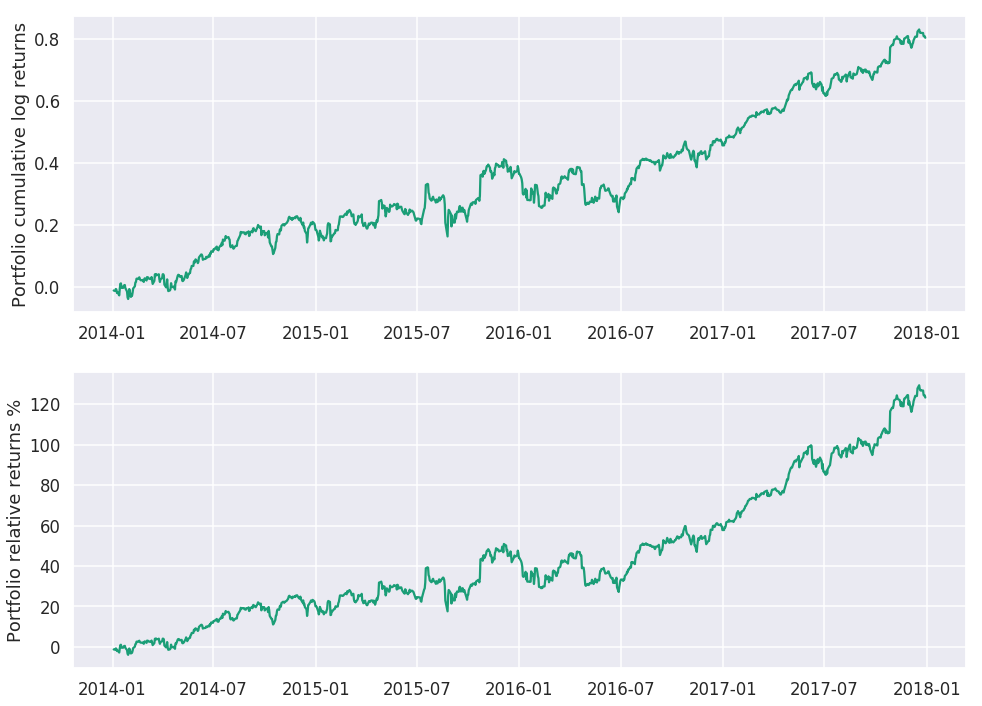

In [35]:
# plot log and rel % returns
total_relative_returns = (np.exp(portfolio_log_returns.cumsum())-1)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,12))

ax1.plot(portfolio_log_returns.index, portfolio_log_returns.cumsum())
ax1.set_ylabel('Portfolio cumulative log returns')

ax2.plot(total_relative_returns.index, 100*total_relative_returns)
ax2.set_ylabel('Portfolio relative returns %')
plt.show()